# Iris dataset

Import the required libraries

In [1]:
# Data

from sklearn.datasets        import load_iris, make_moons
from sklearn.model_selection import train_test_split

# Visualization

import matplotlib.pyplot as plt

# ML model

import torch
import torch.nn    as nn
import torch.optim as optim

from torch_geometric.data   import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn     import MessagePassing
from torch_geometric.utils  import add_self_loops, degree

Basic neural network parameters

In [2]:
num_epochs    = 100
batch_size    = 16
learning_rate = 0.01

Load the Iris dataset

In [3]:
iris     = load_iris()
features = iris.data
labels   = iris.target

Split the dataset into training and testing sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

Convert the data to PyTorch tensors

In [5]:
X_train = torch.Tensor(X_train)
X_test  = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test  = torch.LongTensor(y_test)

Visualize the data

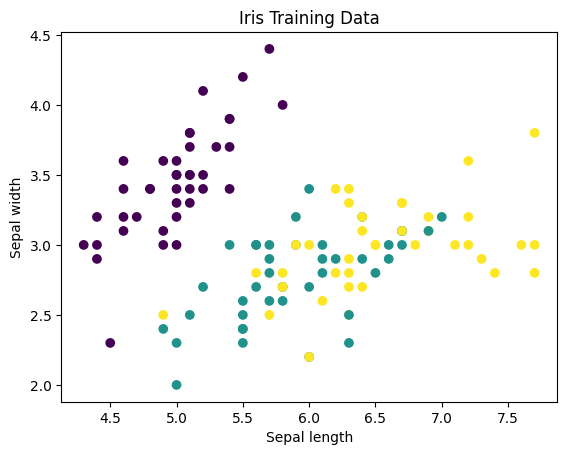

In [6]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('Iris Training Data')
plt.show()

Define the neural network architecture

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(4, 10)  # Fully connected layer 1
        self.fc2 = nn.Linear(10, 10)  # Fully connected layer 2
        self.fc3 = nn.Linear(10, 3)  # Output layer with 3 classes
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to fc1
        x = torch.relu(self.fc2(x))  # Apply ReLU activation to fc2
        x = self.fc3(x)  # Output layer does not have an activation function
        return x

Create an instance of the neural network

In [8]:
model = NeuralNetwork()

Define the loss function and optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

Training the neural network

In [10]:
losses = []
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        targets = y_train[i:i+batch_size]
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    losses.append(loss.item())

Epoch: 10/100, Loss: 1.0496714115142822
Epoch: 20/100, Loss: 1.0068528652191162
Epoch: 30/100, Loss: 0.8816522359848022
Epoch: 40/100, Loss: 0.6907289624214172
Epoch: 50/100, Loss: 0.5640344023704529
Epoch: 60/100, Loss: 0.4994293451309204
Epoch: 70/100, Loss: 0.4483613073825836
Epoch: 80/100, Loss: 0.39420685172080994
Epoch: 90/100, Loss: 0.33759769797325134
Epoch: 100/100, Loss: 0.2766529619693756


Plot the loss curve

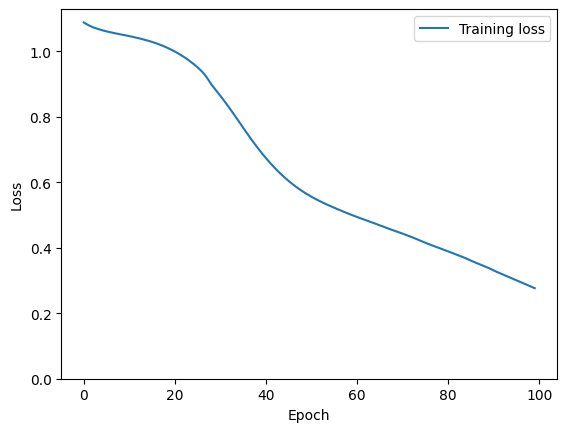

In [11]:
plt.plot(losses, label='Training loss')
plt.ylim(bottom=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

Evaluating the model

In [12]:
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f'Accuracy on test set: {accuracy}')

Accuracy on test set: 0.8666666666666667


# Make moons dataset

Import the required libraries

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch_geometric.data   import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn     import MessagePassing
from torch_geometric.utils  import add_self_loops, degree
from sklearn.datasets       import make_moons

import matplotlib.pyplot as plt

Basic neural network parameters

In [14]:
num_epochs    = 1000
batch_size    = 1
learning_rate = 0.01

Generate the example dataset

In [15]:
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)

Convert the data to PyTorch tensors

In [16]:
X = torch.Tensor(X)
y = torch.Tensor(y)

Convert the data to a graph format

In [17]:
edge_index = torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                           [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0]], dtype=torch.long)
edge_attr = torch.tensor([1] * 32, dtype=torch.float)

data = Data(x=X, y=y, edge_index=edge_index, edge_attr=edge_attr)

Visualize the data

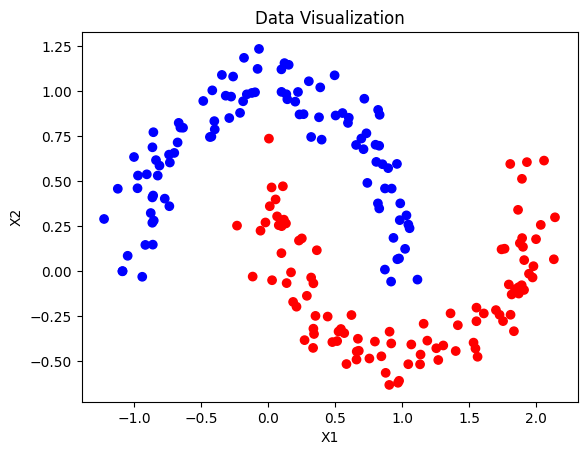

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Data Visualization')
plt.show()

Create a custom Graph Convolutional Layer

In [19]:
class GraphConvolution(MessagePassing):
    def __init__(self):
        super(GraphConvolution, self).__init__(aggr='add')

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        row, col = edge_index

        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

Create the CGNN model

In [20]:
class CGNN(nn.Module):
    def __init__(self):
        super(CGNN, self).__init__()
        self.conv1 = GraphConvolution()
        self.conv2 = GraphConvolution()
        self.fc = nn.Linear(2, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.fc(x)

        return x.view(-1)

Create an instance of the CGNN model

In [21]:
model = CGNN()

Define the loss function and optimizer

In [22]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Create a DataLoader for batching the data

In [23]:
loader = DataLoader([data], batch_size=batch_size, shuffle=True)

Training the CGNN model

In [24]:
losses = []

for epoch in range(num_epochs):
    for batch in loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch.y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch: 10/1000, Loss: 0.37681156396865845
Epoch: 20/1000, Loss: 0.2957893908023834
Epoch: 30/1000, Loss: 0.2421393245458603
Epoch: 40/1000, Loss: 0.21064704656600952
Epoch: 50/1000, Loss: 0.19376255571842194
Epoch: 60/1000, Loss: 0.18443402647972107
Epoch: 70/1000, Loss: 0.17803333699703217
Epoch: 80/1000, Loss: 0.172477126121521
Epoch: 90/1000, Loss: 0.16722221672534943
Epoch: 100/1000, Loss: 0.162277951836586
Epoch: 110/1000, Loss: 0.15771879255771637
Epoch: 120/1000, Loss: 0.15357130765914917
Epoch: 130/1000, Loss: 0.1498308926820755
Epoch: 140/1000, Loss: 0.1464838832616806
Epoch: 150/1000, Loss: 0.1435130536556244
Epoch: 160/1000, Loss: 0.14089734852313995
Epoch: 170/1000, Loss: 0.1386120319366455
Epoch: 180/1000, Loss: 0.136630117893219
Epoch: 190/1000, Loss: 0.13492359220981598
Epoch: 200/1000, Loss: 0.13346442580223083
Epoch: 210/1000, Loss: 0.13222524523735046
Epoch: 220/1000, Loss: 0.13117997348308563
Epoch: 230/1000, Loss: 0.1303039789199829
Epoch: 240/1000, Loss: 0.12957461

Plot the loss curve

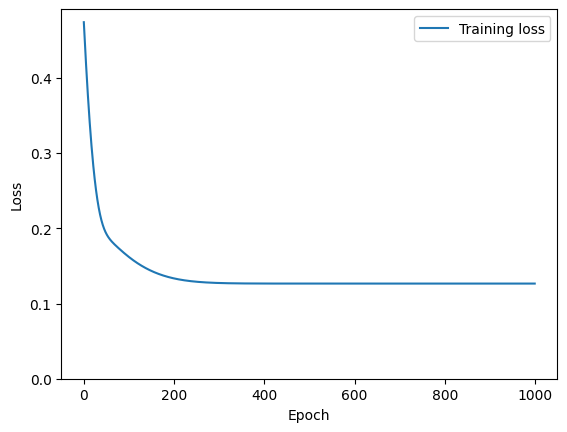

In [25]:
plt.plot(losses, label='Training loss')
plt.ylim(bottom=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

Visualize the predicted values

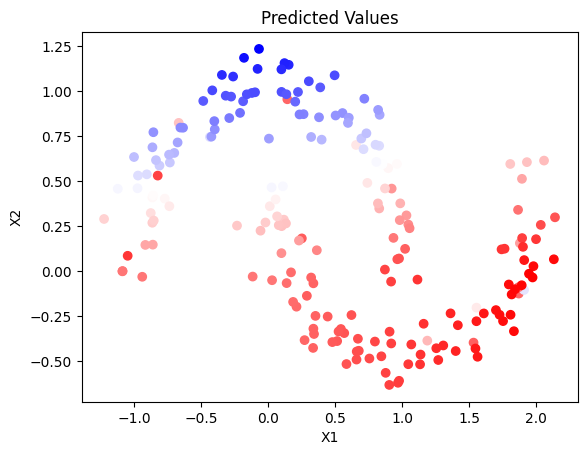

In [26]:
with torch.no_grad():
    predicted = model(data)

plt.scatter(X[:, 0], X[:, 1], c=predicted, cmap='bwr')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Predicted Values')
plt.show()